In [1]:
import os.path as osp

import numpy as np
import torch

from sklearn.cluster import DBSCAN
from torch_geometric.data import Data
import torch_geometric.transforms as ttr
from astropy import table as astropy_table

from mptd.reader import get_raw_data
from mptd.simple_message import SimpleMessage
from mptd.plotter import plot_data, plot_clusters, plot_fits_data
from mptd.smallest_enclosing_circle import welzl


In [2]:
from typing import Any


class MPTDData(Data):
    def __init__(self, x = None, edge_index = None, edge_attr = None, y = None, pos = None, **kwargs):
        assert x is None
        super().__init__(x, edge_index, edge_attr, y, pos, **kwargs)

    @property
    def x(self):
        return self.pos
    
    def append(self, other):
        new_edge_index = torch.hstack([self.edge_index, other.edge_index]) \
                         if other.edge_index is not None and self.edge_index is not None else None
        new_edge_attr = torch.hstack([self.edge_attr, other.edge_attr]) \
                        if other.edge_attr is not None and self.edge_attr is not None else None
        
        return MPTDData(x=torch.vstack([self.x, other.x]), 
                        y=torch.hstack([self.y, other.y]), 
                        pos=torch.vstack([self.y, other.y]), 
                        edge_index=new_edge_index,
                        edge_attr=new_edge_attr
                        )    
 
    def getsplice(self, index):
        y = self.y[index] if self.y is not None else None
        pos = self.pos[index] if self.pos is not None else None

        return MPTDData(y=y, pos=pos)
    
    def __len__(self):
        if self.y is not None:
            return self.y.size(0)
        else:
            raise ValueError("The data object has no valid tensor for indexing.")   

class MPTDDataset:
    def __init__(self, filenames, keys, filters:dict, withsim=True) -> None:
        if type(filenames) is str:
            filenames = [filenames]
        filename = filenames[0]
        ismos = filename.endswith("MIEVLF0000.FTZ") or filename.endswith("MIEVLI0000.FTZ")
        lastcolname = "PHA" if ismos else "TIME_RAW"
        keys_plus = keys + [lastcolname]
        raw_data = get_raw_data(filename, keys_plus, filters)
        for filename in filenames[1:]:
            ismos = filename.endswith("MIEVLF0000.FTZ") or filename.endswith("MIEVLI0000.FTZ")
            lastcolname = "PHA" if ismos else "TIME_RAW"
            keys_plus = keys + [lastcolname]
            raw_data = astropy_table.vstack([raw_data, get_raw_data(filename, keys_plus, filters)])

        issimulated = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).bool()
        self.groups = torch.from_numpy(np.array(raw_data[lastcolname]))
        self.groups[~issimulated] = -1

        if withsim:
            self.data = MPTDData(pos = torch.from_numpy(np.array([raw_data[key] for key in keys]).T).float(),
                                 y = issimulated.long()).cuda()
        else:
            self.data = MPTDData(pos = torch.from_numpy(np.array([raw_data[key] for key in keys]).T[~issimulated]).float(),
                                 y = issimulated[~issimulated].long()).cuda()
            
        self.keys = keys

    def get_group(self, group):
        indices = self.groups == group
        return self.data.pos[indices]
    
    def list_groups(self):
        return torch.unique(self.groups)

class MPTDElaborator:
    def __init__(self, dataset:MPTDDataset, transformer, keys, model) -> None:
        self.dataset = dataset
        self.net_data = transformer(dataset.data)
        self.keys = keys
        self.model = model
        self.iterations = 0
        self.elaborated_data = torch.ones_like(self.net_data.x[:, 0].unsqueeze(-1))#torch.ones((1, self.net_data.x.shape[0]), device=self.net_data.x.device)

    def sizes(self):
        return self.elaborated_data.squeeze()
    
    def distances(self):
        return torch.norm(self.net_data.pos[self.net_data.edge_index[0]] - self.net_data.pos[self.net_data.edge_index[1]], dim=1)
    
    def forward(self, iterations=1):
        for _ in range(iterations):
            self.elaborated_data += self.model.forward(self.elaborated_data, self.net_data.edge_index)
            self.iterations += 1
            self.elaborated_data /= self.elaborated_data.max()
        return self.sizes()
    
    def forward_plot(self, iterations, plot_every=1, plot_after = 0, max_threshold=0.5):
        sizes = self.forward(iterations=plot_after)
        # threshold = torch.quantile(sizes, quantile).item()
        threshold = min(sizes.mean().item(), max_threshold)
        mask = sizes >= threshold
        while self.iterations < iterations:
            plot_data(self.net_data.pos[mask].cpu(), sizes[mask].cpu(), issimulated=self.net_data.y[mask].cpu().bool(), 
                      keys=self.keys, title=f"iteration {self.iterations}", 
                      outfile=osp.join("video_frames", f"frame_{self.iterations:02}.png"))
            sizes = self.forward(iterations=min(iterations - self.iterations, plot_every))
            # threshold = torch.quantile(sizes, quantile).item()
            threshold = min(sizes.mean().item(), max_threshold)
            mask = sizes >= threshold
        
        plot_data(self.net_data.pos[mask].cpu(), sizes[mask].cpu(), issimulated=self.net_data.y[mask].cpu().bool(), 
                  keys=self.keys, title=f"iteration {self.iterations}", 
                  outfile=osp.join("video_frames", f"frame_{self.iterations:02}.png"))

        return sizes

class MPTDClusterer:
    def __init__(self, algorithm, max_threshold):
        self.max_threshold = max_threshold
        self.algorithm = algorithm

    def mask(self, elaborator:MPTDElaborator):
        sizes = elaborator.sizes()
        threshold = min(sizes.mean().item(), self.max_threshold)
        mask = sizes >= threshold
        return mask

    def mask_data(self, elaborator:MPTDElaborator):
        mask = self.mask(elaborator)
        masked_data = elaborator.net_data.getsplice(mask).cpu()
        return masked_data
    
    def cluster(self, elaborator:MPTDElaborator):
        mask = self.mask(elaborator)
        masked_data = elaborator.net_data.getsplice(mask).cpu()
        labels = self.algorithm.fit_predict(masked_data.pos)
        labels_full = np.full((elaborator.net_data.pos.shape[0],), -1)
        labels_full[mask.cpu()] = labels

        return labels_full
    
class MPTDScorer:
    def __init__(self, elaborator:MPTDElaborator):
        self.dataset    = elaborator.dataset
        self.elaborator = elaborator
        self.labels = None

    def predict_labels(self, clusterer:MPTDClusterer):
        self.labels = clusterer.cluster(self.elaborator)
        return self.labels
    
    def fluence_vs_success(self):
        assert self.labels is not None
        return count_and_check_coordinates_grouped(self.dataset.data.pos[self.dataset.data.y.bool()], self.dataset.groups[self.dataset.data.y.bool()], self.dataset.data.pos[self.labels >= 0])
    
    def cluster_accuracy(self):
        assert self.labels is not None
        return count_and_check_coordinates_grouped(self.dataset.data.pos[self.labels >= 0], self.labels[self.labels >= 0], self.dataset.data.pos[self.dataset.data.y.bool()]).T[1].float().mean()

def count_and_check_coordinates(tensors_A, tensor_B):
    # Initialize lists to store the number of points and presence information for each tensor A
    num_points_list = []
    contains_matching_coordinates_list = []

    # Perform element-wise comparison for each tensor in tensors_A
    for tensor_A in tensors_A:
        # Broadcast tensor_B to have the same shape as tensor_A
        expanded_B = tensor_B.unsqueeze(0)  # Shape: (1, B_points, 3)
        expanded_B = expanded_B.expand(tensor_A.shape[0], -1, -1)  # Shape: (A_points, B_points, 3)

        # Perform element-wise comparison to check for matching coordinates
        matched_coordinates = torch.all(tensor_A.unsqueeze(1) == expanded_B, dim=-1)

        # Use torch.any() to check if any coordinate in A matches any coordinate in B for this tensor A
        contains_matching_coordinates = torch.any(matched_coordinates, dim=1)

        # Append the number of points and presence information to their respective lists
        num_points_list.append(tensor_A.shape[0])
        contains_matching_coordinates_list.append(contains_matching_coordinates)

    # Concatenate the lists to create tensors
    num_points_in_A = torch.tensor(num_points_list, dtype=torch.int32).unsqueeze(-1)

    contains_matching_coordinates_tensor = torch.tensor([elems.any(dim=-1) for elems in contains_matching_coordinates_list], dtype=bool).unsqueeze(1)

    # Combine the information about the number of points and matching coordinates into a single tensor
    result_tensor = torch.cat((num_points_in_A, contains_matching_coordinates_tensor.int()), dim=1)

    return result_tensor

def count_and_check_coordinates_grouped(tensor_coordinates, labels, tensor_B):
    unique_labels = np.unique(labels)
    tensors_A = []

    for label in unique_labels:
        # Get the coordinates for the current label
        mask = labels == label
        coordinates_for_label = tensor_coordinates[mask]

        # Append the tensor with coordinates for this label to the list of tensors A
        tensors_A.append(coordinates_for_label)

    # Apply the function for each tensor in tensors_A and store the results in a list
    results = count_and_check_coordinates(tensors_A, tensor_B)

    return results

In [3]:
filenames = []
# filenames.append(osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M1S001MIEVLF0000.FTZ")) # easy example
filenames.append(osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M2S002MIEVLF0000.FTZ")) # easy example
# filenames.append(osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601PNS003PIEVLF0000.FTZ")) # easy example
keys = ["X", "TIME", "Y"]
k = 8
layers = 50
quantile = 0.999
max_threshold = 0.90
filters = {"FLAG": (0,4)}
withsim = True
min_samples = 5

dataset = MPTDDataset(filenames, keys, filters, withsim=withsim)
transformer = ttr.KNNGraph(k=k, force_undirected=True)
model = SimpleMessage()
elaborator = MPTDElaborator(dataset,transformer,keys,model)
elaborator.forward(iterations=layers)
# elaborator.forward_plot(iterations=layers, plot_every=5, max_threshold=max_threshold)

tensor([4.0713e-07, 4.7147e-07, 5.4810e-07,  ..., 1.1939e-06, 3.2988e-06,
        2.5663e-06], device='cuda:0')

In [4]:
# eps = elaborator.distances().median().item()/2
# eps = torch.quantile(elaborator.distances(), quantile).item()
eps = elaborator.distances().max().item()
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusterer = MPTDClusterer(algorithm=dbscan, max_threshold=max_threshold)
scorer = MPTDScorer(elaborator)
labels = scorer.predict_labels(clusterer)

In [5]:
for group in np.unique(scorer.labels):
    if group < 0: continue
    mask = scorer.labels == group
    group_times = scorer.elaborator.dataset.data.pos[mask, 2].cpu()
    time_interval = group_times.max() - group_times.min()
    if time_interval > 10_000:
        print(f"removed group {group}")
        scorer.labels[mask] = -1

In [6]:
mask = labels >= 0
# masked_data = scorer.elaborator.dataset.data.getsplice(mask).cpu()
masked_data = dataset.data.getsplice(mask).cpu()
masked_sizes = scorer.elaborator.elaborated_data[mask].cpu()[:,0]
print(masked_data, len(masked_sizes))
data = scorer.elaborator.dataset.data.cpu()

MPTDData(y=[1175], pos=[1175, 3]) 1175


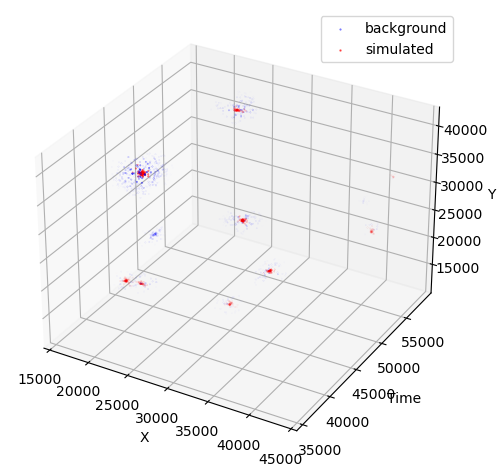

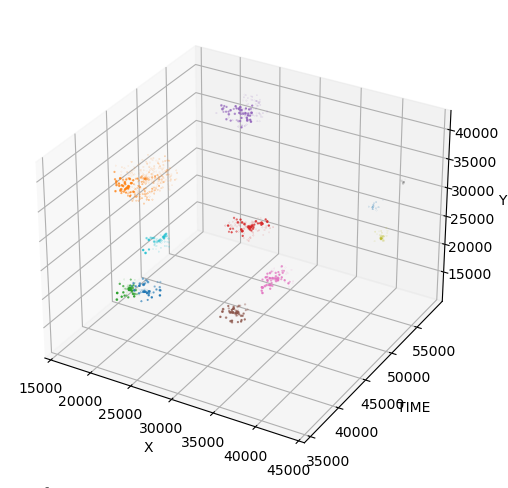

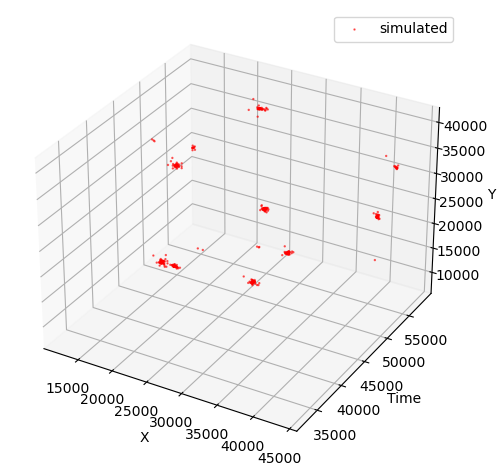

In [7]:
plot_data(masked_data.pos, masked_sizes, masked_data.y.bool(), keys)
plot_clusters(masked_data.pos, masked_sizes, labels[mask].squeeze(), keys, figsize=(6,6))
plot_data(data.pos, (0.0, 0.5), data.y.bool(), keys)

<Axes: title={'center': 'Cluster accuracy: 81.82%'}, xlabel='Fluence', ylabel='Detected'>

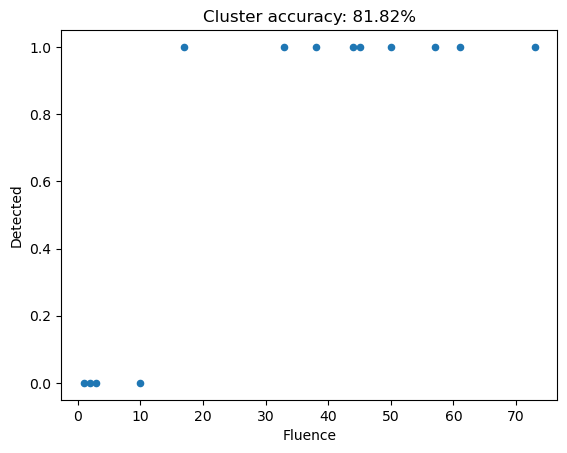

In [8]:
import pandas as pd
from matplotlib import pyplot as plt
df = pd.DataFrame(scorer.fluence_vs_success().float(), columns=["Fluence", "Detected"])
df.groupby("Fluence", axis="rows").mean().reset_index().plot(kind="scatter", x="Fluence", y="Detected", title = "Cluster accuracy: {:.2f}%".format(scorer.cluster_accuracy()*100))